### Challenge
At FakeFashionCorp, we're always looking to **improve our product recommendations for our customers**. As a member of our data science team, your task is to make the best recommendations possible based on the provided data:

- **Customer Search Data**: A list of google search queries made by a **specific** customer. You can find the data in the `./search_history.json` file.
- **Product Catalog**: A dataset containing 100,000 **fashion items** from our current inventory, including details such as product name, category, description, and other relevant attributes. You can find the data in the `./fashion_catalog.json` file.

Your challenge is to analyze the customer's search history and use this information to select the most relevant items from our product catalog that we should recommend to this customer.

Here are the specific requirements:

- Select the top items that best match the customer's apparent interests and preferences.
- Provide a brief explanation of your approach, including any assumptions you made and the reasoning behind your methodology.
- Include any visualizations or metrics that support your recommendations.
- Make sure to include the cell output in the final commit, we will **not** execute the script ourselves.

### Dummy approach
The following is what we consider a **dummy** approach. We expect you to find a more clever solution that this:
1. embed the customer's searches
2. rank the searches according to some semantic similarity to a fashion related anchor
3. for each fashion related search, find the product in the catalog that is most similar

We encourage you to be creative in your approach. There's no single correct solution, and we're interested in seeing how you tackle this real-world problem.

Hint: **how can we truly understand the customer's preferences?**

## Noah Baier Submission
### Problems with the dummy approach
- Development of interests is not modeled (fashion interest can certainly change overtime)
- Important features and attributes are being lost if the whole string is embedded (such as color preferences, sizes, specific brands, price ranges, materials)
- More recent searches should be weighed heavier, repeated searches should also be weighed heavier
- There should be diversity in the recommendations (not all just simiar items)


### My approach & assumptions

Build a holistic model of the user
- Basic fashion preferences (based on the raw counts of searches for fashion related terms)
- Related tag preferences (tags like winter, summer, cotton, wool, streetwear)
- Introduce time decay (recent searches and interest should be deemed more important)

Then, encode the fashion catalog so that each item consists of its category, and any related tags that occur in the description (summer, winter, cotton, etc)


Finally, compute scores for each of the items in the fashion catalog on how well they match the fashion keywords and tag keywords that are of interest to the user

Assumptions:
- Search behavior reflects their genuine interest (maybe they were searching for someone else)

- Tags are binary indicators, i.e. if a tag appears in an item description (one hot encoded), it is deemed equally important as any other tags. In reality, tags like 'summer' might be more important to the user than 'cotton'

- I tried not to assume that other searches like 'elon musk' would indicate something about their fashion interest, but I'm sure there could be interesting insights here too. I.e. try to understand their political preferences, their profession, their hobbies, and then recommend fashion based on that



### Understanding the user

In [23]:
# Display most recent searches
import json
from datetime import datetime
from collections import defaultdict


with open('search_history.json', 'r') as f:
    searches = json.load(f)


search_timestamps = []
for search in searches:
    if 'title' in search and 'Searched for' in search['title']:
        query = search['title'].replace('Searched for ', '')
        timestamp = datetime.fromisoformat(search['time'].replace('Z', '+00:00'))
        search_timestamps.append((query, timestamp))


search_timestamps.sort(key=lambda x: x[1], reverse=True)


print("most recent searches:")
print("-" * 50)
for i, (query, timestamp) in enumerate(search_timestamps[:20], 1):
    print(f"{i}. {query} ({timestamp.strftime('%Y-%m-%d %H:%M:%S')})")

most recent searches:
--------------------------------------------------
1. elon musk shivon zilis (2024-06-23 22:20:47)
2. bank station fire alert (2024-06-23 16:52:09)
3. bank station fire alert (2024-06-23 16:52:00)
4. mukesh ambani house (2024-06-22 20:40:58)
5. sunak (2024-06-22 07:38:19)
6. sunak (2024-06-22 07:38:16)
7. elevenlabs (2024-06-21 21:55:34)
8. balderton talent index for employees (2024-06-21 17:28:24)
9. urban massage (2024-06-21 06:48:49)
10. urban (2024-06-21 06:48:37)
11. made in japan (2024-06-20 16:56:30)
12. akio morita autobiography (2024-06-18 20:07:38)
13. akio morita (2024-06-18 20:07:30)
14. midjourney custom style (2024-06-18 12:10:39)
15. hermes oasis sandals (2024-06-16 22:13:20)
16. hermes sandals (2024-06-16 22:13:11)
17. tory burch raffia sandals (2024-06-16 22:10:32)
18. virgin active london (2024-06-16 19:19:20)
19. mysore road bangalore plots (2024-06-16 13:01:24)
20. airbnb hsr layout (2024-06-16 11:44:31)


### Understanding the categories of the fashion items
I extracted all different categories of the fashion catalog into a csv to make the matching easier later

In [24]:
import pandas as pd

categories_df = pd.read_csv('fashion_categories.csv')
print(f" {len(categories_df)} unique categories")
pd.set_option('display.max_rows', 500)
categories_df.head(25)


 65 unique categories


,Category,Count
0,tops,8434
1,dresses,7651
2,sneakers,6961
3,pants,6774
4,jackets,6700
5,t-shirts,5616
6,knitwear,5314
7,sweats,4470
8,flats,3635
9,heels,3584


### Find most common fashion categories that occur in the search history

In [25]:
import json
import pandas as pd
import re
from collections import Counter

# Load the fashion categories
categories_df = pd.read_csv('fashion_categories.csv')
categories = categories_df['Category'].tolist()

# Load the search history
with open('search_history.json', 'r') as f:
    search_data = json.load(f)

# Function to create regex pattern for each category
def create_category_regex(category):
    # If category has spaces (like "shoulder bags"), handle it as a phrase
    if ' ' in category:
        # Match the exact phrase
        return r'\b' + re.escape(category) + r'\b'
    else:
        # Match the word as a standalone word
        return r'\b' + re.escape(category) + r'\b'

# Dictionary to store matches
category_matches = {category: 0 for category in categories}
matched_searches = {category: [] for category in categories}

# Extract search queries from the data
search_queries = []
for item in search_data:
    if 'title' in item and 'Searched for' in item['title']:
        # Extract the query text after "Searched for "
        query = item['title'].replace('Searched for ', '').lower()
        search_queries.append(query)

# Count matches
for query in search_queries:
    for category in categories:
        pattern = create_category_regex(category.lower())
        if re.search(pattern, query):
            category_matches[category] += 1
            matched_searches[category].append(query)

# Convert to DataFrame for easier viewing
results_df = pd.DataFrame({
    'Category': list(category_matches.keys()),
    'Search_Count': list(category_matches.values())
})

# Sort by count in descending order
results_df = results_df.sort_values('Search_Count', ascending=False)

# Filter to only show categories that were found in searches
found_categories = results_df[results_df['Search_Count'] > 0]

# Display results
print(f"Found {len(found_categories)} fashion categories in search queries")
print(f"Total search queries analyzed: {len(search_queries)}")
print("\nTop fashion categories in searches:")
print(found_categories.head(33))

# Show some example matches for the top categories
if not found_categories.empty:
    print("\nExample searches for top categories:")
    for category in found_categories.head(5)['Category']:
        print(f"\n{category} - {category_matches[category]} matches:")
        # Show up to 5 example searches
        examples = matched_searches[category][:5]
        for ex in examples:
            print(f"  - {ex}")

Found 33 fashion categories in search queries
Total search queries analyzed: 30542

Top fashion categories in searches:
      Category  Search_Count
47        hair           110
10       boots            77
9        heels            52
49     luggage            25
8        flats            20
25     watches            13
1      dresses            12
37     sandals            12
30   underwear            10
21       coats             9
19    lingerie             8
14      shorts             8
27       rings             8
20    earrings             7
3        pants             7
13      shirts             6
6     knitwear             5
46       cases             5
2     sneakers             4
18        hats             3
11       jeans             2
28     scarves             2
40        ties             2
42   messenger             2
17      skirts             2
44       suits             2
63  face masks             2
59    brooches             2
32   jumpsuits             1
5     t-sh

### 1st: General fashion interest of the user
First lets try to get a general picture of the customer based on the categories from the fashion catalog

In [26]:
import pandas as pd
import json
import re
from collections import Counter

# Load fashion categories
categories_df = pd.read_csv('fashion_categories.csv')
categories = categories_df['Category'].tolist()

# Load search history
with open('search_history.json', 'r') as f:
    search_data = json.load(f)

# Step 1: Extract search queries
search_queries = []
for item in search_data:
    if 'title' in item and 'Searched for' in item['title']:
        query = item['title'].replace('Searched for ', '').lower()
        search_queries.append(query)

# Step 2: Count matches
category_matches = {category: 0 for category in categories}

def create_category_regex(category):
    if ' ' in category:
        return r'\b' + re.escape(category) + r'\b'
    else:
        return r'\b' + re.escape(category) + r'\b'

for query in search_queries:
    for category in categories:
        pattern = create_category_regex(category.lower())
        if re.search(pattern, query):
            category_matches[category] += 1

# Step 3: Normalize scores into percentages
total_matches = sum(category_matches.values())
if total_matches > 0:
    normalized_interest = {
        category: count / total_matches
        for category, count in category_matches.items()
        if count > 0
    }
else:
    normalized_interest = {}

# Step 4: Convert to DataFrame
interest_vector_df = pd.DataFrame(list(normalized_interest.items()), columns=['Category', 'InterestScore'])
interest_vector_df = interest_vector_df.sort_values('InterestScore', ascending=False)

# Show result
print("User Interest Vector Based on Search History:")
print(interest_vector_df.head(20))


User Interest Vector Based on Search History:
     Category  InterestScore
29       hair       0.260664
8       boots       0.182464
7       heels       0.123223
30    luggage       0.059242
6       flats       0.047393
19    watches       0.030806
0     dresses       0.028436
24    sandals       0.028436
22  underwear       0.023697
17      coats       0.021327
15   lingerie       0.018957
20      rings       0.018957
12     shorts       0.018957
16   earrings       0.016588
2       pants       0.016588
11     shirts       0.014218
4    knitwear       0.011848
28      cases       0.011848
1    sneakers       0.009479
14       hats       0.007109


This tells us that (based on all searches in the database) the user is mainly interested in hair products, hair cuts, etc,. But there's also interest in shoes, dresses underwear and lingerine. Judging from the searches, the user might be a woman. 

### 2nd: Assisting tags in Google Searches
Next we want to look out for tags like (winter, summer, streetwear, cotton, etc) to recommend items even better based on the season, the material or the style

In [27]:
import re
from collections import defaultdict

# Define your tag categories
season_tags = ['winter', 'summer', 'spring', 'fall', 'autumn', 'cold', 'warm', 'rain']
style_tags = ['streetwear', 'luxury', 'vintage', 'minimalist', 'elegant', 'comfy', 'oversized', 'formal', 'casual']
material_tags = ['cotton', 'wool', 'denim', 'leather', 'silk', 'nylon', 'faux fur', 'polyester']

all_tags = season_tags + style_tags + material_tags

# Initialize frequency counter
tag_counts = defaultdict(int)

# Loop through search queries
for query in search_queries:
    for tag in all_tags:
        if re.search(r'\b' + re.escape(tag) + r'\b', query):
            tag_counts[tag] += 1

# Normalize scores
total_tag_matches = sum(tag_counts.values())
if total_tag_matches > 0:
    normalized_tags = {
        tag: count / total_tag_matches
        for tag, count in tag_counts.items()
    }
else:
    normalized_tags = {}

# Convert to DataFrame
tags_df = pd.DataFrame(list(normalized_tags.items()), columns=['Tag', 'Score'])
tags_df = tags_df.sort_values('Score', ascending=False)

# Show results
print("Assisting Fashion Tags from Searches:")
print(tags_df.head(20))


Assisting Fashion Tags from Searches:
        Tag    Score
3    luxury  0.28750
4    winter  0.13125
8   leather  0.10000
1    summer  0.09375
0    casual  0.06875
5   vintage  0.05000
6      warm  0.04375
7      cold  0.03750
12     fall  0.03750
14   formal  0.03125
15     wool  0.03125
9   elegant  0.02500
10     silk  0.02500
2    spring  0.01875
11    nylon  0.00625
13     rain  0.00625
16   cotton  0.00625


This tells us that the user is interested in luxury items and clothing (they might be open to a higher price range of items). 

### 3rd: Time decay to weigh recent searches heavier than older searches
Next we want to weigh recent searches and interests higher than older ones to make meaningful recommendations that elicit a purchase

In [28]:
import json
from datetime import datetime
from collections import defaultdict
import math

from datetime import datetime, timezone

# CONFIGURATION
lambda_decay = 0.985
reference_date = datetime.now(timezone.utc)  # make it timezone-aware

# Helper function to calculate days ago with timezone handling
def days_ago(timestamp_str):
    timestamp = datetime.fromisoformat(timestamp_str.replace("Z", "+00:00"))
    delta = reference_date - timestamp
    return delta.days + delta.seconds / 86400

# Initialize counters
category_scores = defaultdict(float)
tag_scores = defaultdict(float)

# Loop through search data
for item in search_data:
    if 'title' in item and 'Searched for' in item['title'] and 'time' in item:
        query = item['title'].replace('Searched for ', '').lower()
        time_str = item['time']
        decay = lambda_decay ** days_ago(time_str)

        # Category match
        for category in categories:
            pattern = r'\b' + re.escape(category.lower()) + r'\b'
            if re.search(pattern, query):
                category_scores[category] += decay

        # Tag match
        for tag in all_tags:
            if re.search(r'\b' + re.escape(tag) + r'\b', query):
                tag_scores[tag] += decay

# Normalize category scores
total_cat_score = sum(category_scores.values())
normalized_category_scores = {
    cat: score / total_cat_score for cat, score in category_scores.items()
} if total_cat_score > 0 else {}

# Normalize tag scores
total_tag_score = sum(tag_scores.values())
normalized_tag_scores = {
    tag: score / total_tag_score for tag, score in tag_scores.items()
} if total_tag_score > 0 else {}

# Convert to DataFrames
category_df = pd.DataFrame(list(normalized_category_scores.items()), columns=['Category', 'WeightedScore']).sort_values('WeightedScore', ascending=False)
tag_df = pd.DataFrame(list(normalized_tag_scores.items()), columns=['Tag', 'WeightedScore']).sort_values('WeightedScore', ascending=False)

# Display results
print("Recency-Weighted Fashion Category Preferences:")
print(category_df.head(10))
print("\nRecency-Weighted Assisting Fashion Tags:")
print(tag_df.head(10))


Recency-Weighted Fashion Category Preferences:
    Category  WeightedScore
0    sandals       0.430334
1       hair       0.360567
2     skirts       0.114308
3   earrings       0.028066
7      boots       0.018665
4      rings       0.012509
6      heels       0.009617
8     shorts       0.009584
5      pants       0.009143
11   luggage       0.003876

Recency-Weighted Assisting Fashion Tags:
       Tag  WeightedScore
0   casual       0.472630
1   summer       0.379277
3   luxury       0.080752
2   spring       0.049827
4   winter       0.010028
5  vintage       0.004911
7     cold       0.001490
6     warm       0.000938
9  elegant       0.000089
8  leather       0.000059


Looking at the searches based on recency we can infer that it's probably summer right now (the person recently searched for sandals, skirts, summer, spring, casual). Thus it might make sense to recommend 'summer items'

### 4th: Encode the catalog

Encode the catalog to better match the categories of interest and the other terms of interest such as casual, summer, spring, etc

In [29]:
import re
from collections import defaultdict

# Define global assisting tags
season_tags = ['winter', 'summer', 'spring', 'fall', 'autumn', 'cold', 'warm', 'rain']
style_tags = ['streetwear', 'luxury', 'vintage', 'minimalist', 'elegant', 'comfy', 'oversized', 'formal', 'casual', 'floral', 'lace']
material_tags = ['cotton', 'wool', 'denim', 'leather', 'silk', 'nylon', 'faux fur', 'polyester']
all_tags = season_tags + style_tags + material_tags

# Function to extract tags from text
def extract_tags(text):
    tags = defaultdict(int)
    if not text:
        return tags
    text = text.lower()
    for tag in all_tags:
        if re.search(r'\b' + re.escape(tag) + r'\b', text):
            # One Hot encoding
            tags[tag] = 1
    return tags

# Function to encode catalog items
def encode_catalog_items(catalog):
    encoded = []
    for item in catalog:
        combined_text = f"{item.get('SHORT_DESCRIPTION', '')} {item.get('LONG_DESCRIPTION', '')}"
        tags = extract_tags(combined_text)

        encoded.append({
            'category': item.get('CATEGORY', '').lower(),
            'tags': dict(tags),
            'product_url': item.get('LYST_PRODUCT_URL'),
            'main_image': item.get('MAIN_IMAGE'),
            'short_description': item.get('SHORT_DESCRIPTION', '')
        })
    return encoded




In [30]:
# Create encoded catalog
with open('fashion_catalog.json', 'r') as f:
    fashion_catalog = json.load(f)

encoded_catalog = encode_catalog_items(fashion_catalog)

print(json.dumps(encoded_catalog[:5], indent=2))

[
  {
    "category": "flats",
    "tags": {
      "faux fur": 1
    },
    "product_url": "https://www.lyst.com/shoes/laines-london-classic-laines-slippers-with-pearl-beaded-lobster-shell-brooches-2",
    "main_image": "https://cdna.lystit.com/photos/wolfandbadger/5aeda9ac/laines-london-Brown-Classic-Laines-Slippers-With-Pearl-Beaded-Lobster-Shell-Brooches.jpeg",
    "short_description": "Classic Laines Slippers With Pearl Beaded Lobster & Shell Brooches"
  },
  {
    "category": "skirts",
    "tags": {
      "floral": 1,
      "polyester": 1
    },
    "product_url": "https://www.lyst.com/clothing/oscar-de-la-renta-dahlia-floral-print-midi-skirt",
    "main_image": "https://cdna.lystit.com/photos/farfetch/d774e299/oscar-de-la-renta-red-Gonna-Dahlia-midi-a-fiori.jpeg",
    "short_description": "Dahlia Floral-print Midi Skirt"
  },
  {
    "category": "dresses",
    "tags": {
      "lace": 1,
      "nylon": 1
    },
    "product_url": "https://www.lyst.com/clothing/coperni-green-asymme

### 5th Step: Ranking

Calculate score based on how well the searches match the catalog (based on fashion categories and related tags and recency weighted)

In [31]:
def score_item(item, user_category_vector, user_tag_vector, tag_weight_scale=1.0):
    # Category score
    category_score = user_category_vector.get(item['category'], 0)

    # Tag score
    tag_score = 0
    for tag in item['tags']:
        if tag in user_tag_vector:
            tag_score += user_tag_vector[tag]

    # Combine with scaling factor
    total_score = category_score + tag_weight_scale * tag_score
    return total_score

def rank_items(encoded_catalog, user_category_vector, user_tag_vector, top_n=20):
    scored_items = []
    for item in encoded_catalog:
        score = score_item(item, user_category_vector, user_tag_vector)
        scored_items.append((score, item))

    # Sort items by descending score
    ranked = sorted(scored_items, key=lambda x: x[0], reverse=True)
    return ranked[:top_n]




In [32]:
# Make sure there is diversity in the recommendations
def apply_diversity_constraint(ranked_items, max_per_category, final_count=20):
    category_counts = defaultdict(int)
    diverse_results = []

    for score, item in ranked_items:
        cat = item['category']
        if category_counts[cat] < max_per_category:
            diverse_results.append((score, item))
            category_counts[cat] += 1
        if len(diverse_results) >= final_count:
            break

    return diverse_results


initial_ranked = rank_items(encoded_catalog, normalized_category_scores, normalized_tag_scores, top_n=100)

# filter for diversity
diverse_top_items = apply_diversity_constraint(initial_ranked, max_per_category=3, final_count=20)



In [33]:
for score, item in diverse_top_items:
    print(f"Category     : {item['category'].title()}")
    print(f"Score        : {score:.3f}")
    print(f"Description  : {item.get('short_description', '[No description]')}")
    print(f"Product Link : {item.get('product_url', '[No link]')}")
    print("-" * 60)


Category     : Sandals
Score        : 1.364
Description  : Owners Club Sliders
Product Link : https://www.lyst.com/shoes/represent-text-logo-sliders
------------------------------------------------------------
Category     : Sandals
Score        : 1.282
Description  : Leather Espadrille Sandals
Product Link : https://www.lyst.com/shoes/zegna-leather-espadrille-sandals
------------------------------------------------------------
Category     : Sandals
Score        : 1.282
Description  : Arizona
Product Link : https://www.lyst.com/shoes/birkenstock-arizona-1146
------------------------------------------------------------
Category     : Coats
Score        : 0.993
Description  : Asymmetric Belted Coat
Product Link : https://www.lyst.com/clothing/cole-haan-asymmetric-belted-coat
------------------------------------------------------------
Category     : Tops
Score        : 0.993
Description  : S Classic Ribbed 3/4 Sleeve Henley T-shirt
Product Link : https://www.lyst.com/clothing/tommy-hilf

### Reflection
The final output shows us that, currently, sandals, skirts, and tops could be of high interst to the user. Yet as the user is generally interestd in luxury items, there are also items that had the 'luxury' tag in their description. Diversity is also taken into account, as only recommending sandals would probably not be very interesting to the user.

Below is a visualization of the fashion interest and tag interests to show that the recommendations make sense.


As the user searches for new terms, the newer fashion keywords and tags will be weighted more which results in a dynamic recommendation and shopping experience

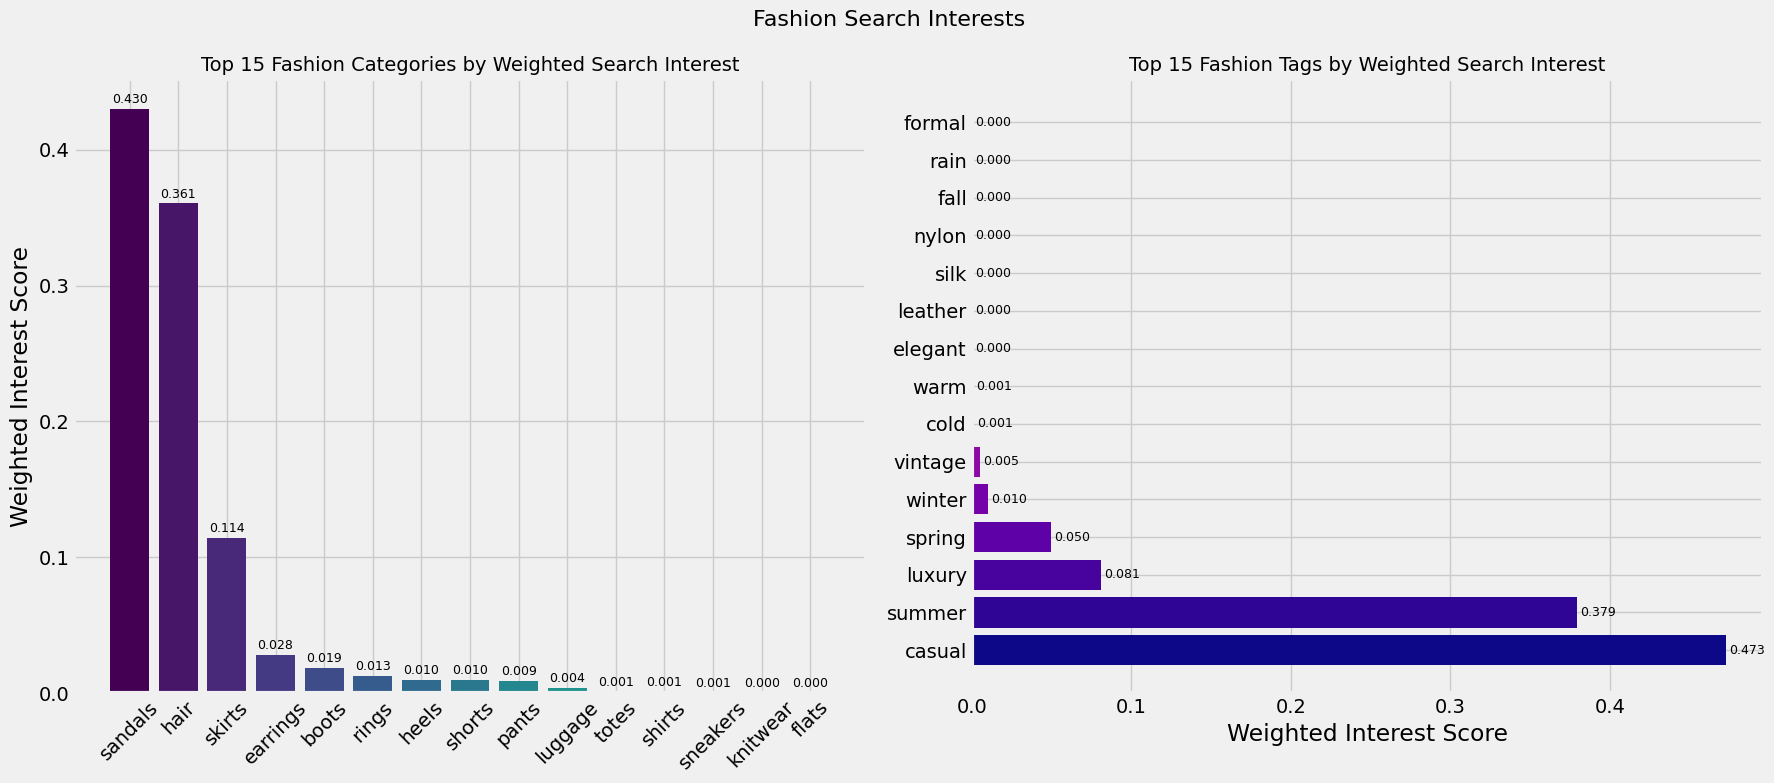

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


plt.style.use('fivethirtyeight')
sns.set_palette('viridis')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))


top_categories = category_df.head(15).copy()
colors = plt.cm.viridis(np.linspace(0, 0.8, len(top_categories)))
bars = ax1.bar(top_categories['Category'], top_categories['WeightedScore'], color=colors)
ax1.set_title('Top 15 Fashion Categories by Weighted Search Interest', fontsize=14)
ax1.set_ylabel('Weighted Interest Score')
ax1.tick_params(axis='x', rotation=45)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)


top_tags = tag_df.head(15).copy()
colors = plt.cm.plasma(np.linspace(0, 0.8, len(top_tags)))
bars = ax2.barh(top_tags['Tag'], top_tags['WeightedScore'], color=colors)
ax2.set_title('Top 15 Fashion Tags by Weighted Search Interest', fontsize=14)
ax2.set_xlabel('Weighted Interest Score')
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width + 0.002, bar.get_y() + bar.get_height()/2.,
             f'{width:.3f}', ha='left', va='center', fontsize=9)

plt.suptitle('Fashion Search Interests', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()